# 以下テンプレート

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [6]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [7]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [8]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [9]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

**Phase2 window flame 作成 & Learning**

In [10]:
def AutoEncoder(TrainWindow,TestWindow,dim,opt,cname,batchSize):
    """
    TrainWindow: 訓練データ
    TestWindow: テストデータ
    dim: 中間層の次元数
    opt: 最適化関数
    cname: 各種データを保存する用の共通の名前
    """
    input_img = Input(shape=( TrainWindow.shape[1] ,))
    encoded = Dense(dim, activation='tanh')(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TrainWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=False,
                    validation_data=(TestWindow, TestWindow)
                    #callbacks=[early_stopping]
                          )
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

In [11]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

In [12]:
GetWindowFrame('AccX',Sensor1['AccX'],256,256/8,WindowDataPath)

this data had finished making


array([[ 0.8825,  0.8755,  0.8711, ...,  0.9233,  0.925 ,  0.9206],
       [ 0.8674,  0.8728,  0.8821, ...,  0.8264,  0.824 ,  0.8271],
       [ 0.8371,  0.8437,  0.8447, ...,  0.8532,  0.8471,  0.8498],
       ..., 
       [-0.1003, -0.0998, -0.0912, ..., -0.0995, -0.0942, -0.0925],
       [-0.1   , -0.1025, -0.1022, ..., -0.0939, -0.0986, -0.0966],
       [-0.0939, -0.0978, -0.0981, ..., -0.0976, -0.1015, -0.0973]])

# denoizng AutoEncoder

ノイズの加え方はとても簡単  

``` python
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
```

以上のように入力データに加えるだけ
いきなり，学習するのではなくノイズを加えたらどのように変化するのかみてみよう

In [13]:
windowRaw = GetWindowFrame('AccX',Sensor1['AccX'],256,32,WindowDataPath)

this data had finished making


In [14]:
noiseFactor =0.5

In [15]:
noiseFactor =0.5
windowNoise = windowRaw + noiseFactor*np.random.normal\
(loc=windowRaw.mean(),scale=windowRaw.std(),size=windowRaw.shape)

In [16]:
print windowRaw.shape
print windowNoise.shape

(33676, 256)
(33676, 256)


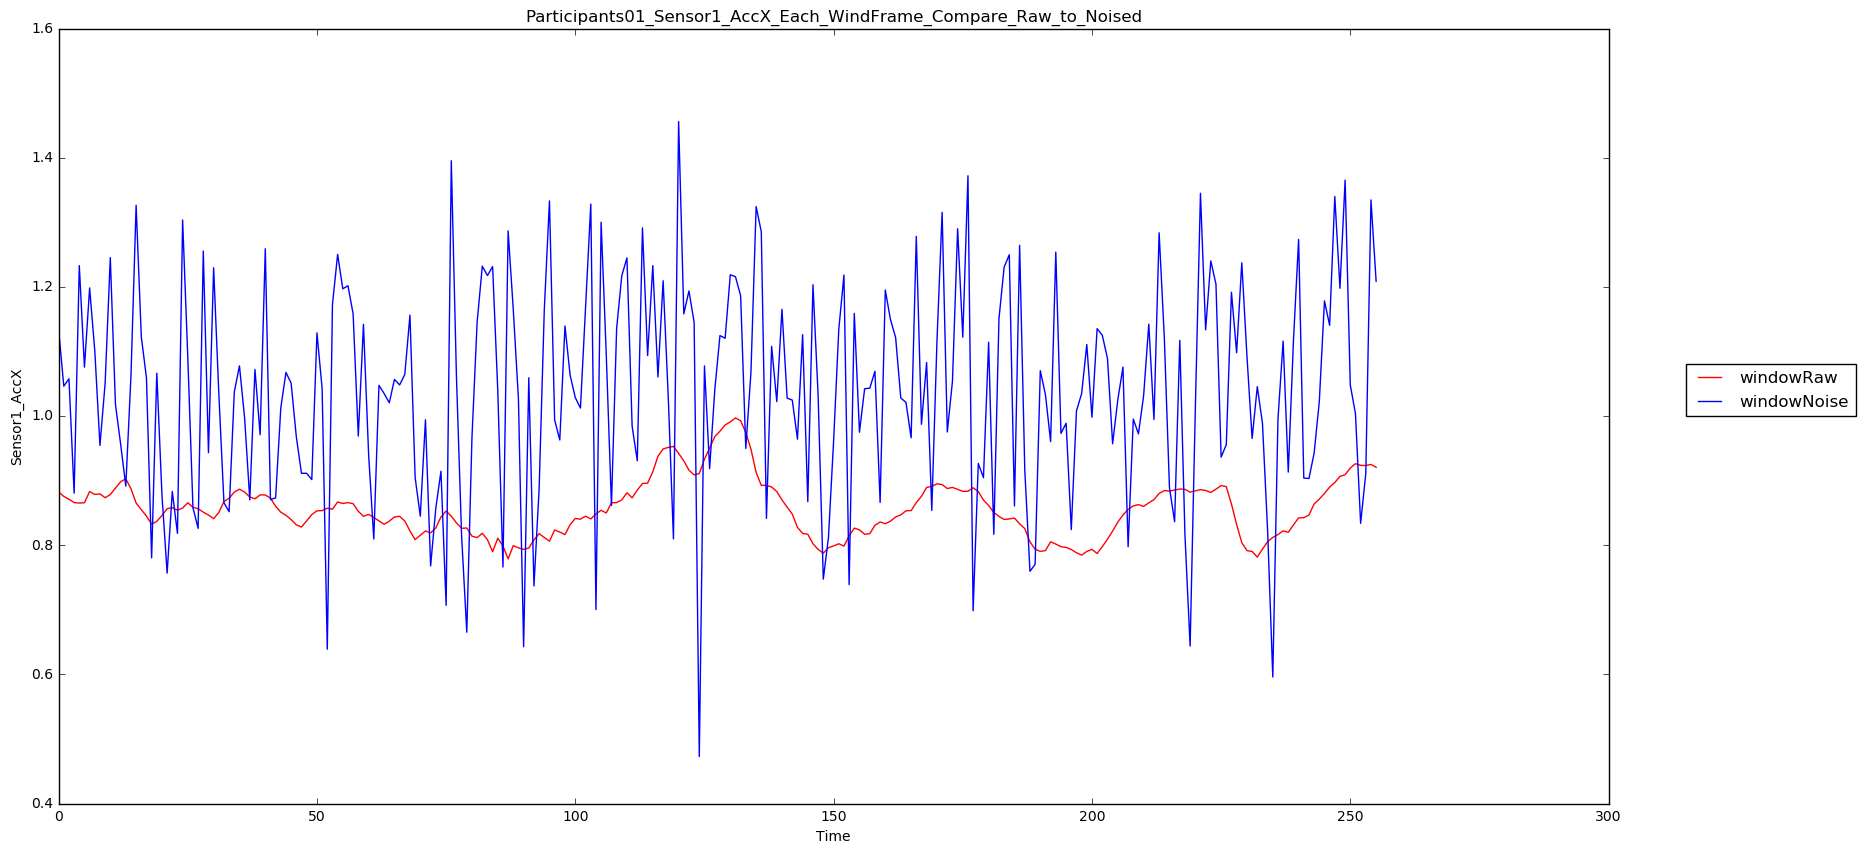

In [17]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')
RngPlotWidth = 5

ax.plot(range(256), windowRaw[0,:],'r',label='windowRaw')
ax.plot(range(256), windowNoise[0,:],'b',label='windowNoise')

lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

ax.set_title("Participants01_Sensor1_AccX_Each_WindFrame_Compare_Raw_to_Noised")
ax.set_ylabel("Sensor1_AccX")


この結果から見ると，ノイズの加え方としてパラメータをどう設定するか問題である．上記のグラフのように，全体の平均や分散でやってしまうと問題である．  
この問題を解決するためにMozartにて，グラフ化を行いノイズをどのように加えていくかを調べる

# 検証内容1
ノイズの重みによって，学習の結果を検証してみる  
以下のパラメータで学習し結果を比較してみる  

固定するパラメータ
* ウィンドウ幅 256
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　adam
* 中間層の次元数 128

this data had finished making
_AEdim=128_Win=0256_Sld=0032_Adam_NoiseFactor=0.001_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0140 - val_loss: 0.0178
Epoch 2/50
2s - loss: 0.0076 - val_loss: 0.0374
Epoch 3/50
2s - loss: 0.0072 - val_loss: 0.0321
Epoch 4/50
2s - loss: 0.0069 - val_loss: 0.0306
Epoch 5/50
2s - loss: 0.0060 - val_loss: 0.0279
Epoch 6/50
2s - loss: 0.0054 - val_loss: 0.0170
Epoch 7/50
2s - loss: 0.0049 - val_loss: 0.0205
Epoch 8/50
2s - loss: 0.0046 - val_loss: 0.0162
Epoch 9/50
2s - loss: 0.0046 - val_loss: 0.0188
Epoch 10/50
2s - loss: 0.0050 - val_loss: 0.0287
Epoch 11/50
2s - loss: 0.0053 - val_loss: 0.0205
Epoch 12/50
2s - loss: 0.0046 - val_loss: 0.0144
Epoch 13/50
2s - loss: 0.0044 - val_loss: 0.0145
Epoch 14/50
2s - loss: 0.0042 - val_loss: 0.0122
Epoch 15/50
2s - loss: 0.0038 - val_loss: 0.0108
Epoch 16/50
2s - loss: 0.0037 - val_loss: 0.0149
Epoch 17/50
2s - loss: 0.0038 - val_loss: 0.0085
Epoch 18/50
2s - loss: 0.0038 - va

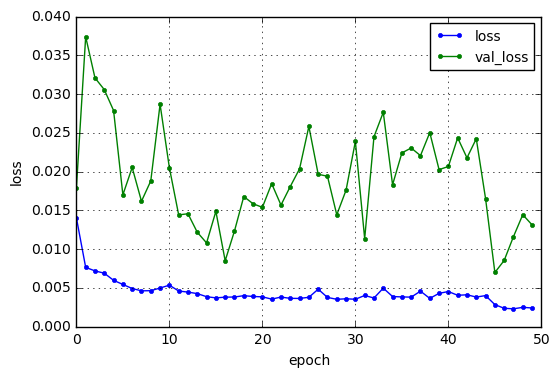

_AEdim=128_Win=0256_Sld=0032_Adam_NoiseFactor=0.005_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0143 - val_loss: 0.0196
Epoch 2/50
2s - loss: 0.0079 - val_loss: 0.0325
Epoch 3/50
2s - loss: 0.0073 - val_loss: 0.0299
Epoch 4/50
2s - loss: 0.0068 - val_loss: 0.0290
Epoch 5/50
2s - loss: 0.0060 - val_loss: 0.0322
Epoch 6/50
2s - loss: 0.0061 - val_loss: 0.0150
Epoch 7/50
2s - loss: 0.0049 - val_loss: 0.0195
Epoch 8/50
2s - loss: 0.0050 - val_loss: 0.0189
Epoch 9/50
2s - loss: 0.0043 - val_loss: 0.0155
Epoch 10/50
2s - loss: 0.0047 - val_loss: 0.0188
Epoch 11/50
2s - loss: 0.0048 - val_loss: 0.0139
Epoch 12/50
2s - loss: 0.0044 - val_loss: 0.0159
Epoch 13/50
2s - loss: 0.0044 - val_loss: 0.0159
Epoch 14/50
2s - loss: 0.0042 - val_loss: 0.0103
Epoch 15/50
2s - loss: 0.0042 - val_loss: 0.0135
Epoch 16/50
2s - loss: 0.0041 - val_loss: 0.0157
Epoch 17/50
2s - loss: 0.0042 - val_loss: 0.0143
Epoch 18/50
1s - loss: 0.0039 - val_loss: 0.0160
Epoch 19/50
2s 

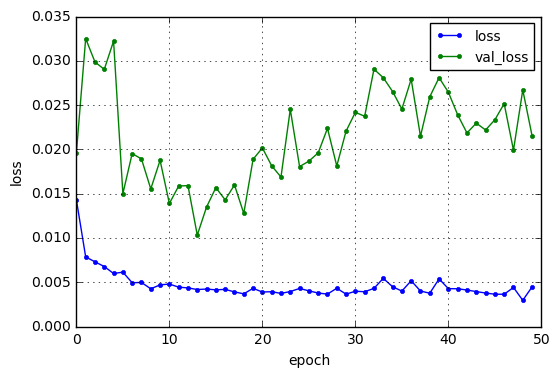

_AEdim=128_Win=0256_Sld=0032_Adam_NoiseFactor=0.01_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0142 - val_loss: 0.0245
Epoch 2/50
1s - loss: 0.0079 - val_loss: 0.0458
Epoch 3/50
2s - loss: 0.0076 - val_loss: 0.0340
Epoch 4/50
2s - loss: 0.0067 - val_loss: 0.0307
Epoch 5/50
1s - loss: 0.0063 - val_loss: 0.0207
Epoch 6/50
1s - loss: 0.0055 - val_loss: 0.0123
Epoch 7/50
2s - loss: 0.0046 - val_loss: 0.0154
Epoch 8/50
2s - loss: 0.0045 - val_loss: 0.0153
Epoch 9/50
2s - loss: 0.0044 - val_loss: 0.0108
Epoch 10/50
1s - loss: 0.0043 - val_loss: 0.0154
Epoch 11/50
2s - loss: 0.0046 - val_loss: 0.0159
Epoch 12/50
2s - loss: 0.0043 - val_loss: 0.0128
Epoch 13/50
2s - loss: 0.0043 - val_loss: 0.0186
Epoch 14/50
2s - loss: 0.0050 - val_loss: 0.0194
Epoch 15/50
2s - loss: 0.0041 - val_loss: 0.0188
Epoch 16/50
2s - loss: 0.0040 - val_loss: 0.0133
Epoch 17/50
2s - loss: 0.0039 - val_loss: 0.0162
Epoch 18/50
2s - loss: 0.0039 - val_loss: 0.0169
Epoch 19/50
2s -

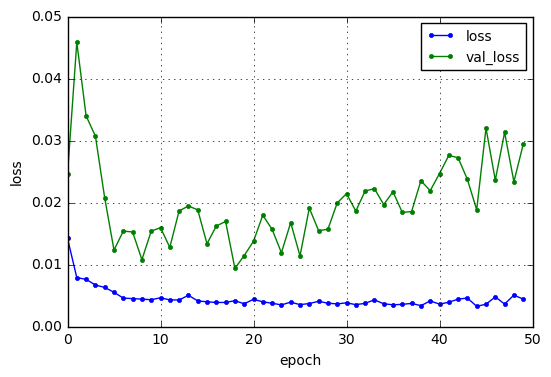

_AEdim=128_Win=0256_Sld=0032_Adam_NoiseFactor=0.05_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0160 - val_loss: 0.0203
Epoch 2/50
2s - loss: 0.0085 - val_loss: 0.0381
Epoch 3/50
2s - loss: 0.0083 - val_loss: 0.0287
Epoch 4/50
2s - loss: 0.0074 - val_loss: 0.0283
Epoch 5/50
2s - loss: 0.0071 - val_loss: 0.0267
Epoch 6/50
1s - loss: 0.0064 - val_loss: 0.0216
Epoch 7/50
2s - loss: 0.0060 - val_loss: 0.0203
Epoch 8/50
2s - loss: 0.0058 - val_loss: 0.0210
Epoch 9/50
2s - loss: 0.0057 - val_loss: 0.0162
Epoch 10/50
2s - loss: 0.0050 - val_loss: 0.0180
Epoch 11/50
2s - loss: 0.0050 - val_loss: 0.0157
Epoch 12/50
2s - loss: 0.0050 - val_loss: 0.0116
Epoch 13/50
2s - loss: 0.0047 - val_loss: 0.0119
Epoch 14/50
2s - loss: 0.0044 - val_loss: 0.0104
Epoch 15/50
2s - loss: 0.0044 - val_loss: 0.0111
Epoch 16/50
2s - loss: 0.0043 - val_loss: 0.0134
Epoch 17/50
2s - loss: 0.0043 - val_loss: 0.0223
Epoch 18/50
2s - loss: 0.0046 - val_loss: 0.0140
Epoch 19/50
2s -

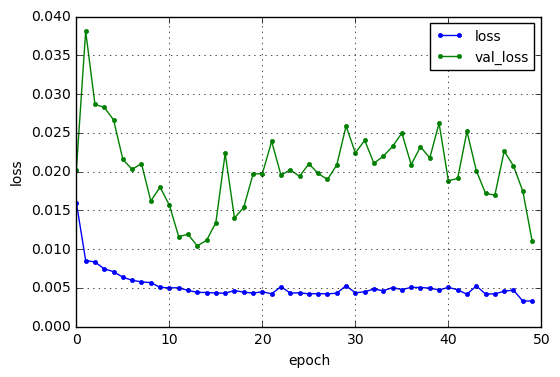

_AEdim=128_Win=0256_Sld=0032_Adam_NoiseFactor=00.1_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
2s - loss: 0.0170 - val_loss: 0.0202
Epoch 2/50
2s - loss: 0.0100 - val_loss: 0.0348
Epoch 3/50
2s - loss: 0.0098 - val_loss: 0.0363
Epoch 4/50
2s - loss: 0.0093 - val_loss: 0.0314
Epoch 5/50
2s - loss: 0.0083 - val_loss: 0.0312
Epoch 6/50
2s - loss: 0.0082 - val_loss: 0.0230
Epoch 7/50
2s - loss: 0.0072 - val_loss: 0.0238
Epoch 8/50
2s - loss: 0.0074 - val_loss: 0.0178
Epoch 9/50
2s - loss: 0.0065 - val_loss: 0.0141
Epoch 10/50
2s - loss: 0.0064 - val_loss: 0.0093
Epoch 11/50
2s - loss: 0.0057 - val_loss: 0.0127
Epoch 12/50
1s - loss: 0.0055 - val_loss: 0.0147
Epoch 13/50
2s - loss: 0.0052 - val_loss: 0.0082
Epoch 14/50
2s - loss: 0.0053 - val_loss: 0.0117
Epoch 15/50
2s - loss: 0.0052 - val_loss: 0.0101
Epoch 16/50
1s - loss: 0.0052 - val_loss: 0.0199
Epoch 17/50
1s - loss: 0.0056 - val_loss: 0.0150
Epoch 18/50
1s - loss: 0.0053 - val_loss: 0.0104
Epoch 19/50
1s -

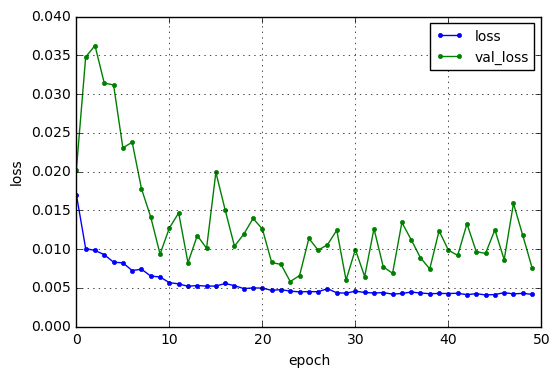

_AEdim=128_Win=0256_Sld=0032_Adam_NoiseFactor=00.5_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0561 - val_loss: 0.0260
Epoch 2/50
1s - loss: 0.0366 - val_loss: 0.0084
Epoch 3/50
1s - loss: 0.0307 - val_loss: 0.0089
Epoch 4/50
1s - loss: 0.0272 - val_loss: 0.0073
Epoch 5/50
1s - loss: 0.0231 - val_loss: 0.0065
Epoch 6/50
1s - loss: 0.0255 - val_loss: 0.0127
Epoch 7/50
1s - loss: 0.0241 - val_loss: 0.0156
Epoch 8/50
0s - loss: 0.0232 - val_loss: 0.0110
Epoch 9/50
0s - loss: 0.0222 - val_loss: 0.0089
Epoch 10/50
1s - loss: 0.0216 - val_loss: 0.0101
Epoch 11/50
1s - loss: 0.0220 - val_loss: 0.0125
Epoch 12/50
1s - loss: 0.0227 - val_loss: 0.0075
Epoch 13/50
1s - loss: 0.0219 - val_loss: 0.0073
Epoch 14/50
1s - loss: 0.0212 - val_loss: 0.0093
Epoch 15/50
1s - loss: 0.0212 - val_loss: 0.0094
Epoch 16/50
1s - loss: 0.0207 - val_loss: 0.0060
Epoch 17/50
1s - loss: 0.0205 - val_loss: 0.0090
Epoch 18/50
1s - loss: 0.0205 - val_loss: 0.0101
Epoch 19/50
1s -

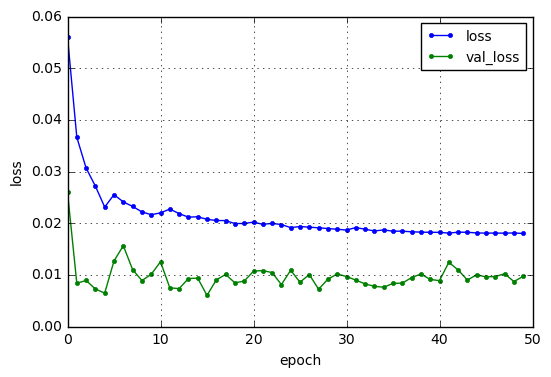

In [18]:
# loop windowWidth
WindowWidth = 256
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 128

WeightNoise=np.array([ 0.001,0.005,0.010,0.05,0.100,0.500 ])
windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowWidth,SlidingWidth,WindowDataPath)

for wn in WeightNoise:    
    windowNoise = windoW  + wn*np.random.normal\
    (loc=windoW.mean(),scale=windoW.std(),size=windoW.shape)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowWidth).zfill(4)+\
    '_Sld='+str(SlidingWidth).zfill(4)+'_'+Optim+'_NoiseFactor='+str(wn).zfill(4)\
    +'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容2
ノイズの重みによって，学習の結果を検証してみる  
以下のパラメータで学習し結果を比較してみる  

Adamだとダメなのかもしれないので，一度ＳＧＤでやる  

固定するパラメータ
* ウィンドウ幅 256
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

this data had finished making
_AEdim=128_Win=0256_Sld=0032_sgd_NoiseFactor=0.001_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0664 - val_loss: 0.0147
Epoch 2/50
1s - loss: 0.0121 - val_loss: 0.0130
Epoch 3/50
1s - loss: 0.0106 - val_loss: 0.0117
Epoch 4/50
1s - loss: 0.0097 - val_loss: 0.0108
Epoch 5/50
1s - loss: 0.0090 - val_loss: 0.0102
Epoch 6/50
1s - loss: 0.0085 - val_loss: 0.0097
Epoch 7/50
1s - loss: 0.0081 - val_loss: 0.0093
Epoch 8/50
1s - loss: 0.0078 - val_loss: 0.0089
Epoch 9/50
1s - loss: 0.0075 - val_loss: 0.0086
Epoch 10/50
1s - loss: 0.0073 - val_loss: 0.0084
Epoch 11/50
1s - loss: 0.0071 - val_loss: 0.0082
Epoch 12/50
0s - loss: 0.0069 - val_loss: 0.0080
Epoch 13/50
0s - loss: 0.0067 - val_loss: 0.0078
Epoch 14/50
1s - loss: 0.0066 - val_loss: 0.0076
Epoch 15/50
1s - loss: 0.0064 - val_loss: 0.0075
Epoch 16/50
1s - loss: 0.0063 - val_loss: 0.0073
Epoch 17/50
1s - loss: 0.0062 - val_loss: 0.0072
Epoch 18/50
1s - loss: 0.0061 - val

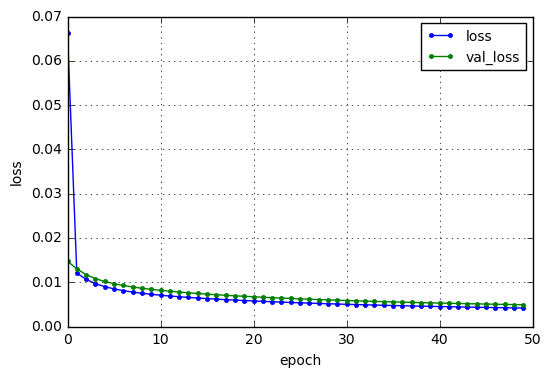

_AEdim=128_Win=0256_Sld=0032_sgd_NoiseFactor=0.005_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0683 - val_loss: 0.0144
Epoch 2/50
1s - loss: 0.0119 - val_loss: 0.0128
Epoch 3/50
1s - loss: 0.0106 - val_loss: 0.0117
Epoch 4/50
1s - loss: 0.0098 - val_loss: 0.0109
Epoch 5/50
1s - loss: 0.0092 - val_loss: 0.0103
Epoch 6/50
1s - loss: 0.0087 - val_loss: 0.0099
Epoch 7/50
1s - loss: 0.0084 - val_loss: 0.0095
Epoch 8/50
1s - loss: 0.0081 - val_loss: 0.0092
Epoch 9/50
1s - loss: 0.0078 - val_loss: 0.0089
Epoch 10/50
1s - loss: 0.0076 - val_loss: 0.0087
Epoch 11/50
1s - loss: 0.0074 - val_loss: 0.0085
Epoch 12/50
1s - loss: 0.0072 - val_loss: 0.0083
Epoch 13/50
1s - loss: 0.0071 - val_loss: 0.0081
Epoch 14/50
1s - loss: 0.0069 - val_loss: 0.0080
Epoch 15/50
1s - loss: 0.0068 - val_loss: 0.0078
Epoch 16/50
1s - loss: 0.0067 - val_loss: 0.0077
Epoch 17/50
1s - loss: 0.0065 - val_loss: 0.0075
Epoch 18/50
1s - loss: 0.0064 - val_loss: 0.0074
Epoch 19/50
2s -

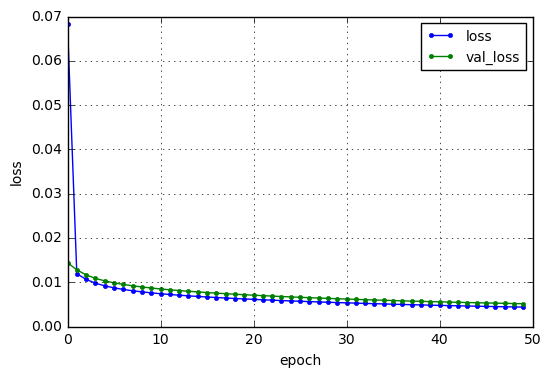

_AEdim=128_Win=0256_Sld=0032_sgd_NoiseFactor=0.01_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0742 - val_loss: 0.0156
Epoch 2/50
1s - loss: 0.0128 - val_loss: 0.0137
Epoch 3/50
1s - loss: 0.0113 - val_loss: 0.0123
Epoch 4/50
1s - loss: 0.0102 - val_loss: 0.0113
Epoch 5/50
0s - loss: 0.0095 - val_loss: 0.0107
Epoch 6/50
0s - loss: 0.0090 - val_loss: 0.0102
Epoch 7/50
1s - loss: 0.0086 - val_loss: 0.0098
Epoch 8/50
1s - loss: 0.0082 - val_loss: 0.0094
Epoch 9/50
1s - loss: 0.0080 - val_loss: 0.0091
Epoch 10/50
1s - loss: 0.0077 - val_loss: 0.0089
Epoch 11/50
1s - loss: 0.0075 - val_loss: 0.0086
Epoch 12/50
1s - loss: 0.0073 - val_loss: 0.0084
Epoch 13/50
1s - loss: 0.0072 - val_loss: 0.0083
Epoch 14/50
1s - loss: 0.0070 - val_loss: 0.0081
Epoch 15/50
1s - loss: 0.0069 - val_loss: 0.0079
Epoch 16/50
1s - loss: 0.0067 - val_loss: 0.0078
Epoch 17/50
1s - loss: 0.0066 - val_loss: 0.0077
Epoch 18/50
1s - loss: 0.0065 - val_loss: 0.0075
Epoch 19/50
1s - 

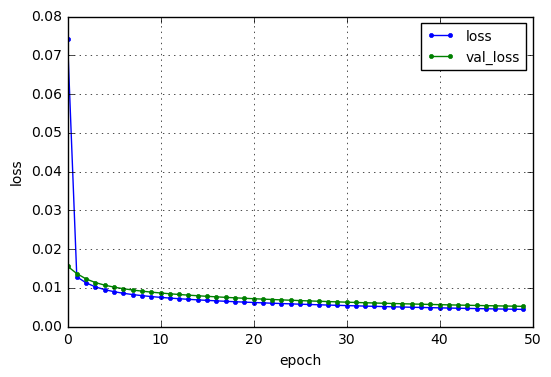

_AEdim=128_Win=0256_Sld=0032_sgd_NoiseFactor=0.05_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0740 - val_loss: 0.0157
Epoch 2/50
1s - loss: 0.0135 - val_loss: 0.0141
Epoch 3/50
1s - loss: 0.0120 - val_loss: 0.0127
Epoch 4/50
1s - loss: 0.0109 - val_loss: 0.0117
Epoch 5/50
1s - loss: 0.0101 - val_loss: 0.0110
Epoch 6/50
1s - loss: 0.0095 - val_loss: 0.0104
Epoch 7/50
1s - loss: 0.0091 - val_loss: 0.0100
Epoch 8/50
1s - loss: 0.0087 - val_loss: 0.0096
Epoch 9/50
1s - loss: 0.0084 - val_loss: 0.0093
Epoch 10/50
1s - loss: 0.0082 - val_loss: 0.0090
Epoch 11/50
1s - loss: 0.0080 - val_loss: 0.0088
Epoch 12/50
1s - loss: 0.0078 - val_loss: 0.0085
Epoch 13/50
1s - loss: 0.0076 - val_loss: 0.0084
Epoch 14/50
1s - loss: 0.0074 - val_loss: 0.0082
Epoch 15/50
1s - loss: 0.0073 - val_loss: 0.0080
Epoch 16/50
1s - loss: 0.0072 - val_loss: 0.0079
Epoch 17/50
1s - loss: 0.0070 - val_loss: 0.0077
Epoch 18/50
1s - loss: 0.0069 - val_loss: 0.0076
Epoch 19/50
1s - 

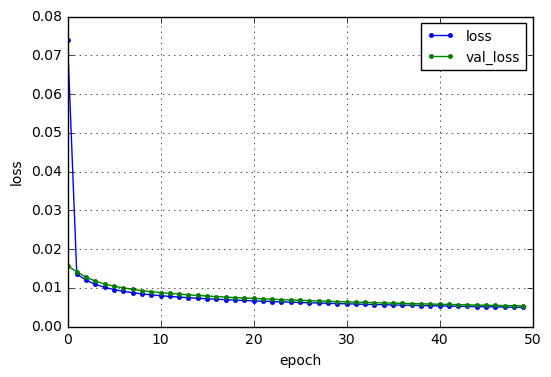

_AEdim=128_Win=0256_Sld=0032_sgd_NoiseFactor=00.1_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.0798 - val_loss: 0.0154
Epoch 2/50
1s - loss: 0.0148 - val_loss: 0.0140
Epoch 3/50
1s - loss: 0.0132 - val_loss: 0.0126
Epoch 4/50
1s - loss: 0.0121 - val_loss: 0.0117
Epoch 5/50
1s - loss: 0.0113 - val_loss: 0.0110
Epoch 6/50
1s - loss: 0.0108 - val_loss: 0.0105
Epoch 7/50
1s - loss: 0.0104 - val_loss: 0.0100
Epoch 8/50
1s - loss: 0.0100 - val_loss: 0.0097
Epoch 9/50
1s - loss: 0.0097 - val_loss: 0.0094
Epoch 10/50
1s - loss: 0.0095 - val_loss: 0.0091
Epoch 11/50
1s - loss: 0.0093 - val_loss: 0.0089
Epoch 12/50
1s - loss: 0.0091 - val_loss: 0.0087
Epoch 13/50
1s - loss: 0.0089 - val_loss: 0.0085
Epoch 14/50
1s - loss: 0.0088 - val_loss: 0.0083
Epoch 15/50
1s - loss: 0.0086 - val_loss: 0.0081
Epoch 16/50
1s - loss: 0.0085 - val_loss: 0.0080
Epoch 17/50
1s - loss: 0.0084 - val_loss: 0.0078
Epoch 18/50
1s - loss: 0.0082 - val_loss: 0.0077
Epoch 19/50
1s - 

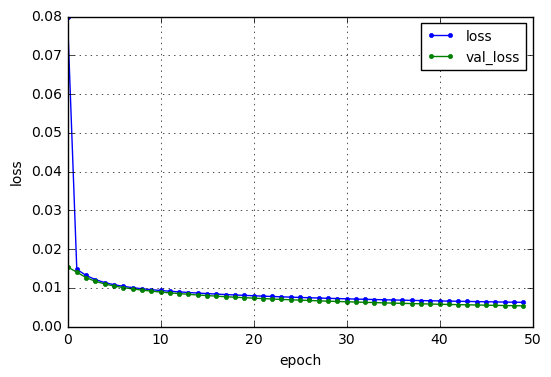

_AEdim=128_Win=0256_Sld=0032_sgd_NoiseFactor=00.5_denoising
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.1346 - val_loss: 0.0262
Epoch 2/50
1s - loss: 0.0590 - val_loss: 0.0231
Epoch 3/50
1s - loss: 0.0561 - val_loss: 0.0211
Epoch 4/50
1s - loss: 0.0543 - val_loss: 0.0199
Epoch 5/50
1s - loss: 0.0531 - val_loss: 0.0192
Epoch 6/50
1s - loss: 0.0522 - val_loss: 0.0187
Epoch 7/50
1s - loss: 0.0515 - val_loss: 0.0183
Epoch 8/50
1s - loss: 0.0509 - val_loss: 0.0180
Epoch 9/50
1s - loss: 0.0504 - val_loss: 0.0177
Epoch 10/50
1s - loss: 0.0500 - val_loss: 0.0175
Epoch 11/50
1s - loss: 0.0496 - val_loss: 0.0173
Epoch 12/50
1s - loss: 0.0493 - val_loss: 0.0172
Epoch 13/50
1s - loss: 0.0490 - val_loss: 0.0170
Epoch 14/50
1s - loss: 0.0487 - val_loss: 0.0169
Epoch 15/50
1s - loss: 0.0484 - val_loss: 0.0167
Epoch 16/50
1s - loss: 0.0482 - val_loss: 0.0166
Epoch 17/50
1s - loss: 0.0479 - val_loss: 0.0164
Epoch 18/50
1s - loss: 0.0476 - val_loss: 0.0163
Epoch 19/50
1s - 

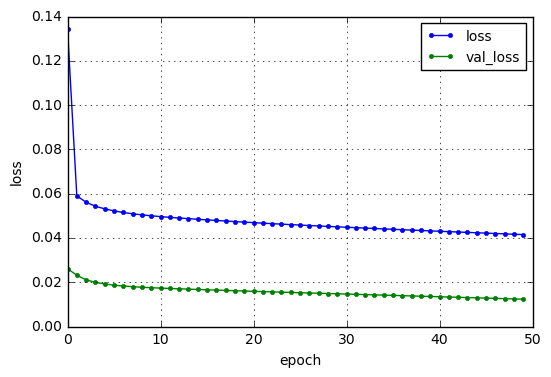

In [19]:
# loop windowWidth
WindowWidth = 256
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
AEDimention = 128

WeightNoise=np.array([ 0.001,0.005,0.010,0.05,0.100,0.500 ])
windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowWidth,SlidingWidth,WindowDataPath)

for wn in WeightNoise:    
    windowNoise = windoW  + wn*np.random.normal\
    (loc=windoW.mean(),scale=windoW.std(),size=windoW.shape)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowWidth).zfill(4)+\
    '_Sld='+str(SlidingWidth).zfill(4)+'_'+Optim+'_NoiseFactor='+str(wn).zfill(4)\
    +'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容3
ノイズの重みによって，学習の結果を検証してみる  
以下のパラメータで学習し結果を比較してみる  

Adamだとダメなのかもしれないので，一度ＳＧＤでやる  
ウィンドウフレームを大きくする

固定するパラメータ
* ウィンドウ幅 512
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

this data had finished making
_AEdim=128_Win=0512_Sld=0064_sgd_NoiseFactor=0.001_denoising
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.1819 - val_loss: 0.0857
Epoch 2/50
1s - loss: 0.0494 - val_loss: 0.0285
Epoch 3/50
1s - loss: 0.0226 - val_loss: 0.0196
Epoch 4/50
1s - loss: 0.0180 - val_loss: 0.0175
Epoch 5/50
1s - loss: 0.0165 - val_loss: 0.0163
Epoch 6/50
1s - loss: 0.0154 - val_loss: 0.0154
Epoch 7/50
0s - loss: 0.0146 - val_loss: 0.0148
Epoch 8/50
1s - loss: 0.0140 - val_loss: 0.0142
Epoch 9/50
1s - loss: 0.0135 - val_loss: 0.0138
Epoch 10/50
1s - loss: 0.0131 - val_loss: 0.0134
Epoch 11/50
0s - loss: 0.0127 - val_loss: 0.0131
Epoch 12/50
1s - loss: 0.0124 - val_loss: 0.0128
Epoch 13/50
0s - loss: 0.0121 - val_loss: 0.0126
Epoch 14/50
0s - loss: 0.0119 - val_loss: 0.0124
Epoch 15/50
1s - loss: 0.0116 - val_loss: 0.0122
Epoch 16/50
0s - loss: 0.0114 - val_loss: 0.0120
Epoch 17/50
0s - loss: 0.0112 - val_loss: 0.0118
Epoch 18/50
0s - loss: 0.0111 - val

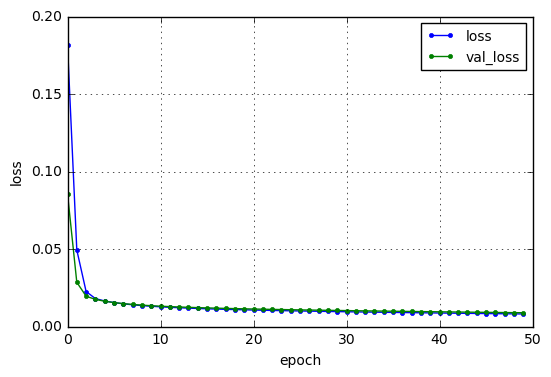

_AEdim=128_Win=0512_Sld=0064_sgd_NoiseFactor=0.005_denoising
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.1854 - val_loss: 0.0896
Epoch 2/50
1s - loss: 0.0516 - val_loss: 0.0290
Epoch 3/50
1s - loss: 0.0227 - val_loss: 0.0193
Epoch 4/50
0s - loss: 0.0177 - val_loss: 0.0171
Epoch 5/50
0s - loss: 0.0161 - val_loss: 0.0159
Epoch 6/50
1s - loss: 0.0151 - val_loss: 0.0151
Epoch 7/50
0s - loss: 0.0143 - val_loss: 0.0144
Epoch 8/50
0s - loss: 0.0137 - val_loss: 0.0139
Epoch 9/50
1s - loss: 0.0132 - val_loss: 0.0135
Epoch 10/50
0s - loss: 0.0127 - val_loss: 0.0131
Epoch 11/50
0s - loss: 0.0124 - val_loss: 0.0128
Epoch 12/50
0s - loss: 0.0121 - val_loss: 0.0125
Epoch 13/50
0s - loss: 0.0118 - val_loss: 0.0123
Epoch 14/50
0s - loss: 0.0116 - val_loss: 0.0121
Epoch 15/50
0s - loss: 0.0113 - val_loss: 0.0119
Epoch 16/50
1s - loss: 0.0111 - val_loss: 0.0117
Epoch 17/50
0s - loss: 0.0110 - val_loss: 0.0116
Epoch 18/50
0s - loss: 0.0108 - val_loss: 0.0114
Epoch 19/50
0s -

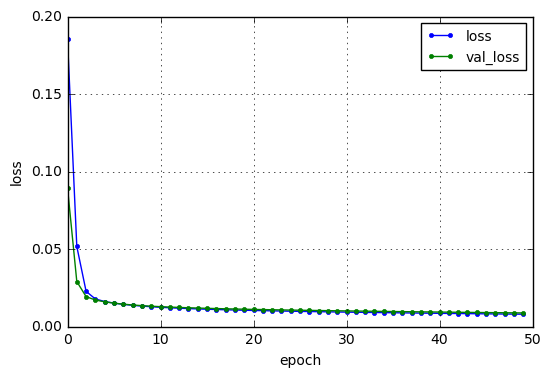

_AEdim=128_Win=0512_Sld=0064_sgd_NoiseFactor=0.01_denoising
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.1940 - val_loss: 0.0978
Epoch 2/50
0s - loss: 0.0570 - val_loss: 0.0313
Epoch 3/50
0s - loss: 0.0241 - val_loss: 0.0199
Epoch 4/50
0s - loss: 0.0182 - val_loss: 0.0174
Epoch 5/50
0s - loss: 0.0164 - val_loss: 0.0162
Epoch 6/50
0s - loss: 0.0153 - val_loss: 0.0153
Epoch 7/50
0s - loss: 0.0145 - val_loss: 0.0146
Epoch 8/50
0s - loss: 0.0138 - val_loss: 0.0140
Epoch 9/50
0s - loss: 0.0133 - val_loss: 0.0136
Epoch 10/50
0s - loss: 0.0128 - val_loss: 0.0132
Epoch 11/50
0s - loss: 0.0125 - val_loss: 0.0129
Epoch 12/50
0s - loss: 0.0121 - val_loss: 0.0126
Epoch 13/50
0s - loss: 0.0119 - val_loss: 0.0123
Epoch 14/50
0s - loss: 0.0116 - val_loss: 0.0121
Epoch 15/50
0s - loss: 0.0114 - val_loss: 0.0119
Epoch 16/50
0s - loss: 0.0112 - val_loss: 0.0118
Epoch 17/50
0s - loss: 0.0110 - val_loss: 0.0116
Epoch 18/50
0s - loss: 0.0108 - val_loss: 0.0115
Epoch 19/50
0s - 

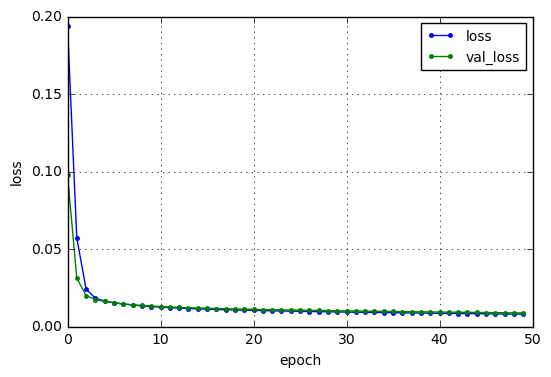

_AEdim=128_Win=0512_Sld=0064_sgd_NoiseFactor=0.05_denoising
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.1863 - val_loss: 0.0827
Epoch 2/50
0s - loss: 0.0510 - val_loss: 0.0274
Epoch 3/50
0s - loss: 0.0237 - val_loss: 0.0193
Epoch 4/50
0s - loss: 0.0190 - val_loss: 0.0173
Epoch 5/50
0s - loss: 0.0172 - val_loss: 0.0162
Epoch 6/50
0s - loss: 0.0161 - val_loss: 0.0153
Epoch 7/50
0s - loss: 0.0152 - val_loss: 0.0146
Epoch 8/50
0s - loss: 0.0145 - val_loss: 0.0141
Epoch 9/50
0s - loss: 0.0139 - val_loss: 0.0136
Epoch 10/50
0s - loss: 0.0134 - val_loss: 0.0132
Epoch 11/50
0s - loss: 0.0130 - val_loss: 0.0129
Epoch 12/50
0s - loss: 0.0126 - val_loss: 0.0126
Epoch 13/50
0s - loss: 0.0123 - val_loss: 0.0124
Epoch 14/50
0s - loss: 0.0120 - val_loss: 0.0122
Epoch 15/50
0s - loss: 0.0118 - val_loss: 0.0120
Epoch 16/50
0s - loss: 0.0116 - val_loss: 0.0118
Epoch 17/50
0s - loss: 0.0114 - val_loss: 0.0116
Epoch 18/50
0s - loss: 0.0112 - val_loss: 0.0115
Epoch 19/50
0s - 

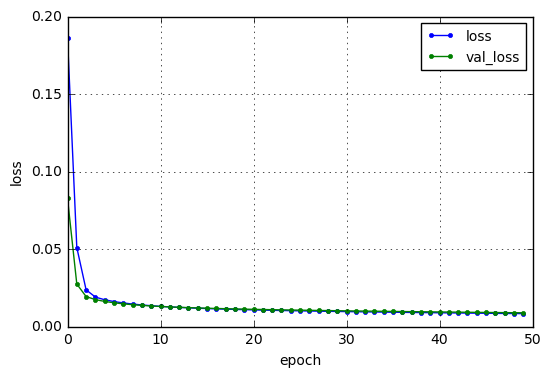

_AEdim=128_Win=0512_Sld=0064_sgd_NoiseFactor=00.1_denoising
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.1989 - val_loss: 0.0785
Epoch 2/50
0s - loss: 0.0514 - val_loss: 0.0250
Epoch 3/50
0s - loss: 0.0243 - val_loss: 0.0185
Epoch 4/50
0s - loss: 0.0201 - val_loss: 0.0169
Epoch 5/50
0s - loss: 0.0184 - val_loss: 0.0159
Epoch 6/50
0s - loss: 0.0173 - val_loss: 0.0151
Epoch 7/50
0s - loss: 0.0164 - val_loss: 0.0145
Epoch 8/50
0s - loss: 0.0157 - val_loss: 0.0141
Epoch 9/50
0s - loss: 0.0152 - val_loss: 0.0137
Epoch 10/50
0s - loss: 0.0148 - val_loss: 0.0134
Epoch 11/50
0s - loss: 0.0144 - val_loss: 0.0132
Epoch 12/50
0s - loss: 0.0141 - val_loss: 0.0129
Epoch 13/50
0s - loss: 0.0138 - val_loss: 0.0127
Epoch 14/50
0s - loss: 0.0135 - val_loss: 0.0126
Epoch 15/50
0s - loss: 0.0133 - val_loss: 0.0124
Epoch 16/50
0s - loss: 0.0131 - val_loss: 0.0122
Epoch 17/50
0s - loss: 0.0129 - val_loss: 0.0121
Epoch 18/50
0s - loss: 0.0127 - val_loss: 0.0120
Epoch 19/50
0s - 

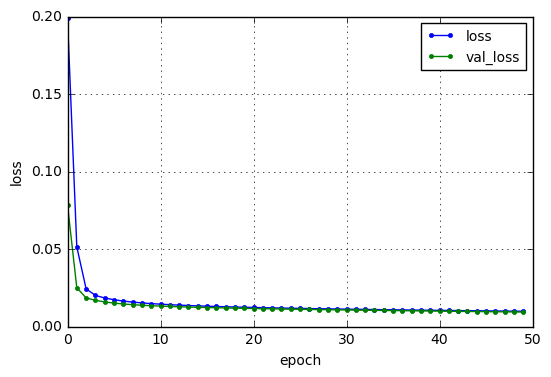

_AEdim=128_Win=0512_Sld=0064_sgd_NoiseFactor=00.5_denoising
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2844 - val_loss: 0.0385
Epoch 2/50
0s - loss: 0.0823 - val_loss: 0.0241
Epoch 3/50
0s - loss: 0.0646 - val_loss: 0.0241
Epoch 4/50
0s - loss: 0.0607 - val_loss: 0.0228
Epoch 5/50
0s - loss: 0.0583 - val_loss: 0.0219
Epoch 6/50
0s - loss: 0.0567 - val_loss: 0.0213
Epoch 7/50
0s - loss: 0.0556 - val_loss: 0.0210
Epoch 8/50
0s - loss: 0.0548 - val_loss: 0.0207
Epoch 9/50
0s - loss: 0.0542 - val_loss: 0.0205
Epoch 10/50
0s - loss: 0.0537 - val_loss: 0.0203
Epoch 11/50
0s - loss: 0.0533 - val_loss: 0.0201
Epoch 12/50
0s - loss: 0.0530 - val_loss: 0.0199
Epoch 13/50
0s - loss: 0.0527 - val_loss: 0.0198
Epoch 14/50
0s - loss: 0.0524 - val_loss: 0.0196
Epoch 15/50
0s - loss: 0.0522 - val_loss: 0.0195
Epoch 16/50
0s - loss: 0.0519 - val_loss: 0.0193
Epoch 17/50
0s - loss: 0.0517 - val_loss: 0.0192
Epoch 18/50
0s - loss: 0.0515 - val_loss: 0.0191
Epoch 19/50
0s - 

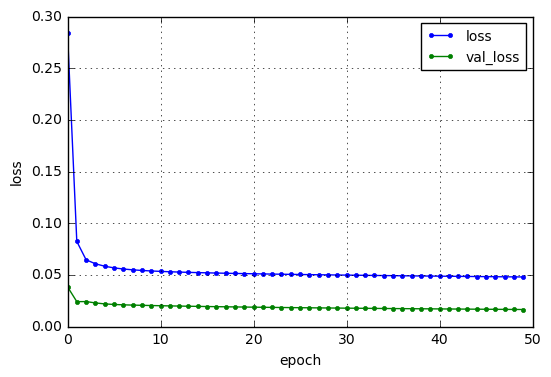

In [20]:
# loop windowWidth
WindowWidth = 512
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
AEDimention = 128

WeightNoise=np.array([ 0.001,0.005,0.010,0.05,0.100,0.500 ])
windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowWidth,SlidingWidth,WindowDataPath)

for wn in WeightNoise:    
    windowNoise = windoW  + wn*np.random.normal\
    (loc=windoW.mean(),scale=windoW.std(),size=windoW.shape)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowWidth).zfill(4)+\
    '_Sld='+str(SlidingWidth).zfill(4)+'_'+Optim+'_NoiseFactor='+str(wn).zfill(4)\
    +'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容4
ノイズの重みによって，学習の結果を検証してみる  
以下のパラメータで学習し結果を比較してみる  

Adamだとダメなのかもしれないので，一度ＳＧＤでやる  
ウィンドウフレームを大きくする

固定するパラメータ
* ウィンドウ幅 1024
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

this data had finished making
_AEdim=128_Win=1024_Sld=0128_sgd_NoiseFactor=0.001_denoising
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2731 - val_loss: 0.2332
Epoch 2/50
0s - loss: 0.2044 - val_loss: 0.1748
Epoch 3/50
0s - loss: 0.1475 - val_loss: 0.1215
Epoch 4/50
0s - loss: 0.1009 - val_loss: 0.0824
Epoch 5/50
0s - loss: 0.0694 - val_loss: 0.0580
Epoch 6/50
0s - loss: 0.0504 - val_loss: 0.0439
Epoch 7/50
0s - loss: 0.0396 - val_loss: 0.0360
Epoch 8/50
0s - loss: 0.0335 - val_loss: 0.0314
Epoch 9/50
0s - loss: 0.0299 - val_loss: 0.0286
Epoch 10/50
0s - loss: 0.0275 - val_loss: 0.0267
Epoch 11/50
0s - loss: 0.0259 - val_loss: 0.0253
Epoch 12/50
0s - loss: 0.0247 - val_loss: 0.0242
Epoch 13/50
0s - loss: 0.0237 - val_loss: 0.0233
Epoch 14/50
0s - loss: 0.0229 - val_loss: 0.0226
Epoch 15/50
0s - loss: 0.0222 - val_loss: 0.0220
Epoch 16/50
0s - loss: 0.0216 - val_loss: 0.0214
Epoch 17/50
0s - loss: 0.0211 - val_loss: 0.0210
Epoch 18/50
0s - loss: 0.0207 - val_l

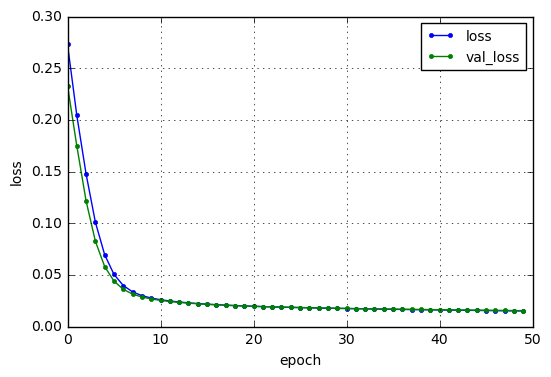

_AEdim=128_Win=1024_Sld=0128_sgd_NoiseFactor=0.005_denoising
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2850 - val_loss: 0.2401
Epoch 2/50
0s - loss: 0.2085 - val_loss: 0.1750
Epoch 3/50
0s - loss: 0.1468 - val_loss: 0.1189
Epoch 4/50
0s - loss: 0.0985 - val_loss: 0.0795
Epoch 5/50
0s - loss: 0.0671 - val_loss: 0.0559
Epoch 6/50
0s - loss: 0.0490 - val_loss: 0.0427
Epoch 7/50
0s - loss: 0.0389 - val_loss: 0.0354
Epoch 8/50
0s - loss: 0.0333 - val_loss: 0.0312
Epoch 9/50
0s - loss: 0.0300 - val_loss: 0.0286
Epoch 10/50
0s - loss: 0.0278 - val_loss: 0.0269
Epoch 11/50
0s - loss: 0.0263 - val_loss: 0.0255
Epoch 12/50
0s - loss: 0.0251 - val_loss: 0.0245
Epoch 13/50
0s - loss: 0.0241 - val_loss: 0.0237
Epoch 14/50
0s - loss: 0.0233 - val_loss: 0.0229
Epoch 15/50
0s - loss: 0.0226 - val_loss: 0.0223
Epoch 16/50
0s - loss: 0.0221 - val_loss: 0.0218
Epoch 17/50
0s - loss: 0.0215 - val_loss: 0.0213
Epoch 18/50
0s - loss: 0.0211 - val_loss: 0.0209
Epoch 19/50
0s - l

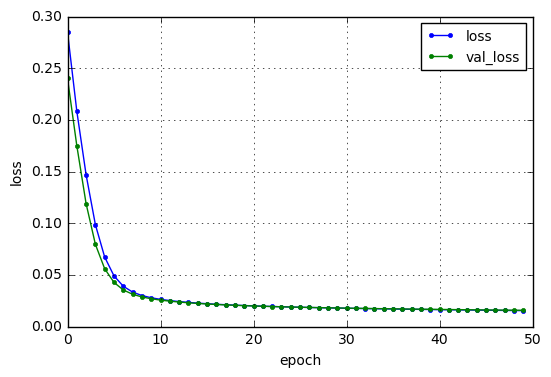

_AEdim=128_Win=1024_Sld=0128_sgd_NoiseFactor=0.01_denoising
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2706 - val_loss: 0.2254
Epoch 2/50
0s - loss: 0.1952 - val_loss: 0.1609
Epoch 3/50
0s - loss: 0.1347 - val_loss: 0.1075
Epoch 4/50
0s - loss: 0.0897 - val_loss: 0.0722
Epoch 5/50
0s - loss: 0.0618 - val_loss: 0.0515
Epoch 6/50
0s - loss: 0.0460 - val_loss: 0.0401
Epoch 7/50
0s - loss: 0.0372 - val_loss: 0.0338
Epoch 8/50
0s - loss: 0.0323 - val_loss: 0.0302
Epoch 9/50
0s - loss: 0.0293 - val_loss: 0.0279
Epoch 10/50
0s - loss: 0.0273 - val_loss: 0.0262
Epoch 11/50
0s - loss: 0.0258 - val_loss: 0.0250
Epoch 12/50
0s - loss: 0.0247 - val_loss: 0.0240
Epoch 13/50
0s - loss: 0.0238 - val_loss: 0.0232
Epoch 14/50
0s - loss: 0.0230 - val_loss: 0.0225
Epoch 15/50
0s - loss: 0.0223 - val_loss: 0.0219
Epoch 16/50
0s - loss: 0.0217 - val_loss: 0.0213
Epoch 17/50
0s - loss: 0.0212 - val_loss: 0.0209
Epoch 18/50
0s - loss: 0.0207 - val_loss: 0.0205
Epoch 19/50
0s - lo

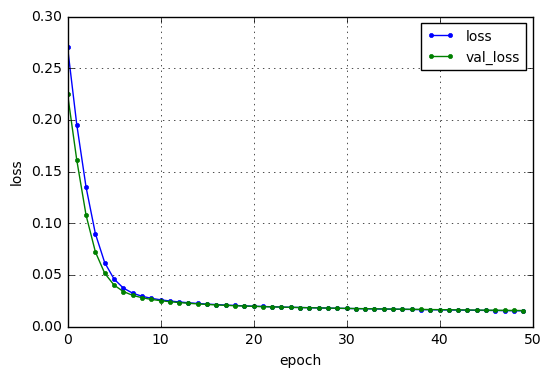

_AEdim=128_Win=1024_Sld=0128_sgd_NoiseFactor=0.05_denoising
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2735 - val_loss: 0.2137
Epoch 2/50
0s - loss: 0.1920 - val_loss: 0.1492
Epoch 3/50
0s - loss: 0.1306 - val_loss: 0.0984
Epoch 4/50
0s - loss: 0.0868 - val_loss: 0.0659
Epoch 5/50
0s - loss: 0.0602 - val_loss: 0.0474
Epoch 6/50
0s - loss: 0.0453 - val_loss: 0.0374
Epoch 7/50
0s - loss: 0.0372 - val_loss: 0.0320
Epoch 8/50
0s - loss: 0.0325 - val_loss: 0.0288
Epoch 9/50
0s - loss: 0.0297 - val_loss: 0.0267
Epoch 10/50
0s - loss: 0.0277 - val_loss: 0.0253
Epoch 11/50
0s - loss: 0.0263 - val_loss: 0.0241
Epoch 12/50
0s - loss: 0.0251 - val_loss: 0.0232
Epoch 13/50
0s - loss: 0.0242 - val_loss: 0.0225
Epoch 14/50
0s - loss: 0.0234 - val_loss: 0.0218
Epoch 15/50
0s - loss: 0.0227 - val_loss: 0.0213
Epoch 16/50
0s - loss: 0.0222 - val_loss: 0.0208
Epoch 17/50
0s - loss: 0.0217 - val_loss: 0.0204
Epoch 18/50
0s - loss: 0.0212 - val_loss: 0.0200
Epoch 19/50
0s - lo

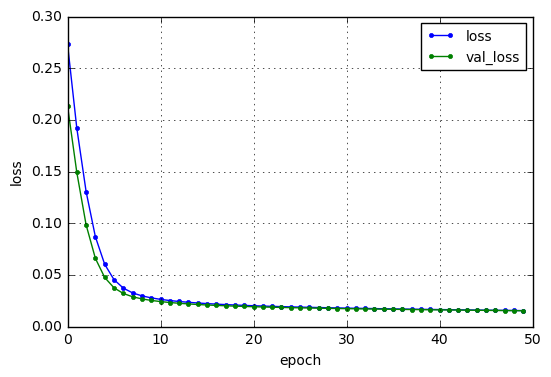

_AEdim=128_Win=1024_Sld=0128_sgd_NoiseFactor=00.1_denoising
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2926 - val_loss: 0.2166
Epoch 2/50
0s - loss: 0.2072 - val_loss: 0.1500
Epoch 3/50
0s - loss: 0.1398 - val_loss: 0.0969
Epoch 4/50
0s - loss: 0.0917 - val_loss: 0.0634
Epoch 5/50
0s - loss: 0.0629 - val_loss: 0.0451
Epoch 6/50
0s - loss: 0.0472 - val_loss: 0.0356
Epoch 7/50
0s - loss: 0.0388 - val_loss: 0.0305
Epoch 8/50
0s - loss: 0.0340 - val_loss: 0.0277
Epoch 9/50
0s - loss: 0.0311 - val_loss: 0.0258
Epoch 10/50
0s - loss: 0.0292 - val_loss: 0.0245
Epoch 11/50
0s - loss: 0.0277 - val_loss: 0.0234
Epoch 12/50
0s - loss: 0.0265 - val_loss: 0.0226
Epoch 13/50
0s - loss: 0.0255 - val_loss: 0.0219
Epoch 14/50
0s - loss: 0.0247 - val_loss: 0.0213
Epoch 15/50
0s - loss: 0.0240 - val_loss: 0.0208
Epoch 16/50
0s - loss: 0.0234 - val_loss: 0.0204
Epoch 17/50
0s - loss: 0.0229 - val_loss: 0.0200
Epoch 18/50
0s - loss: 0.0224 - val_loss: 0.0197
Epoch 19/50
0s - lo

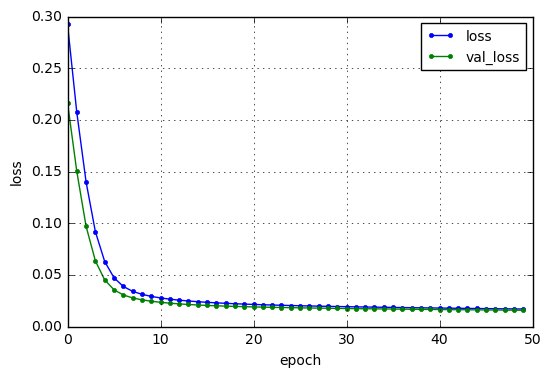

_AEdim=128_Win=1024_Sld=0128_sgd_NoiseFactor=00.5_denoising
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.4612 - val_loss: 0.1907
Epoch 2/50
0s - loss: 0.2975 - val_loss: 0.1053
Epoch 3/50
0s - loss: 0.1853 - val_loss: 0.0573
Epoch 4/50
0s - loss: 0.1242 - val_loss: 0.0379
Epoch 5/50
0s - loss: 0.0956 - val_loss: 0.0314
Epoch 6/50
0s - loss: 0.0822 - val_loss: 0.0292
Epoch 7/50
0s - loss: 0.0753 - val_loss: 0.0280
Epoch 8/50
0s - loss: 0.0710 - val_loss: 0.0270
Epoch 9/50
0s - loss: 0.0680 - val_loss: 0.0260
Epoch 10/50
0s - loss: 0.0657 - val_loss: 0.0253
Epoch 11/50
0s - loss: 0.0640 - val_loss: 0.0249
Epoch 12/50
0s - loss: 0.0626 - val_loss: 0.0246
Epoch 13/50
0s - loss: 0.0615 - val_loss: 0.0244
Epoch 14/50
0s - loss: 0.0606 - val_loss: 0.0242
Epoch 15/50
0s - loss: 0.0598 - val_loss: 0.0241
Epoch 16/50
0s - loss: 0.0592 - val_loss: 0.0241
Epoch 17/50
0s - loss: 0.0587 - val_loss: 0.0240
Epoch 18/50
0s - loss: 0.0582 - val_loss: 0.0240
Epoch 19/50
0s - lo

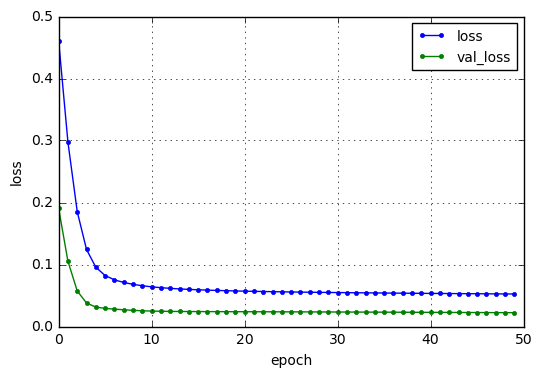

In [21]:
# loop windowWidth
WindowWidth = 1024
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
AEDimention = 128

WeightNoise=np.array([ 0.001,0.005,0.010,0.05,0.100,0.500 ])
windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowWidth,SlidingWidth,WindowDataPath)

for wn in WeightNoise:    
    windowNoise = windoW  + wn*np.random.normal\
    (loc=windoW.mean(),scale=windoW.std(),size=windoW.shape)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowWidth).zfill(4)+\
    '_Sld='+str(SlidingWidth).zfill(4)+'_'+Optim+'_NoiseFactor='+str(wn).zfill(4)\
    +'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容4
ノイズの重みによって，学習の結果を検証してみる  
以下のパラメータで学習し結果を比較してみる  

Adamだとダメなのかもしれないので，一度ＳＧＤでやる  
ウィンドウフレームを大きくする

固定するパラメータ
* ウィンドウ幅 2024
* スライド幅 ウィンドウ幅/8
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

  8%|▊         | 326/4252 [00:00<00:01, 3247.60it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =4253
offset=90


100%|██████████| 4252/4252 [01:30<00:00, 46.77it/s]


_AEdim=128_Win=2024_Sld=0253_sgd_NoiseFactor=0.001_denoising
Train on 4253 samples, validate on 4253 samples
Epoch 1/50
0s - loss: 0.5542 - val_loss: 0.5162
Epoch 2/50
0s - loss: 0.4862 - val_loss: 0.4529
Epoch 3/50
0s - loss: 0.4194 - val_loss: 0.3833
Epoch 4/50
0s - loss: 0.3501 - val_loss: 0.3160
Epoch 5/50
0s - loss: 0.2867 - val_loss: 0.2575
Epoch 6/50
0s - loss: 0.2334 - val_loss: 0.2096
Epoch 7/50
0s - loss: 0.1905 - val_loss: 0.1717
Epoch 8/50
0s - loss: 0.1569 - val_loss: 0.1423
Epoch 9/50
0s - loss: 0.1310 - val_loss: 0.1198
Epoch 10/50
0s - loss: 0.1112 - val_loss: 0.1025
Epoch 11/50
0s - loss: 0.0960 - val_loss: 0.0894
Epoch 12/50
0s - loss: 0.0844 - val_loss: 0.0793
Epoch 13/50
0s - loss: 0.0755 - val_loss: 0.0715
Epoch 14/50
0s - loss: 0.0685 - val_loss: 0.0654
Epoch 15/50
0s - loss: 0.0631 - val_loss: 0.0605
Epoch 16/50
0s - loss: 0.0587 - val_loss: 0.0566
Epoch 17/50
0s - loss: 0.0551 - val_loss: 0.0533
Epoch 18/50
0s - loss: 0.0521 - val_loss: 0.0506
Epoch 19/50
0s - l

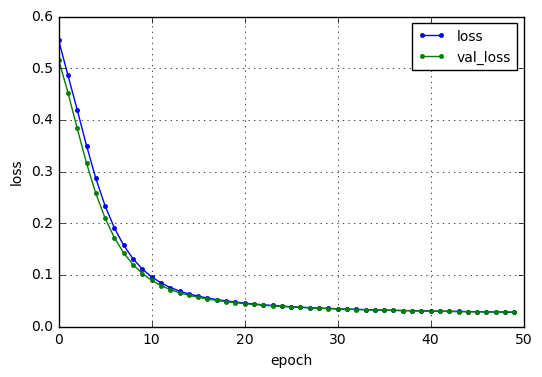

_AEdim=128_Win=2024_Sld=0253_sgd_NoiseFactor=0.005_denoising
Train on 4253 samples, validate on 4253 samples
Epoch 1/50
0s - loss: 0.5610 - val_loss: 0.5136
Epoch 2/50
0s - loss: 0.4835 - val_loss: 0.4444
Epoch 3/50
0s - loss: 0.4127 - val_loss: 0.3736
Epoch 4/50
0s - loss: 0.3433 - val_loss: 0.3076
Epoch 5/50
0s - loss: 0.2815 - val_loss: 0.2511
Epoch 6/50
0s - loss: 0.2299 - val_loss: 0.2052
Epoch 7/50
0s - loss: 0.1885 - val_loss: 0.1688
Epoch 8/50
0s - loss: 0.1561 - val_loss: 0.1405
Epoch 9/50
0s - loss: 0.1309 - val_loss: 0.1187
Epoch 10/50
0s - loss: 0.1115 - val_loss: 0.1020
Epoch 11/50
0s - loss: 0.0966 - val_loss: 0.0891
Epoch 12/50
0s - loss: 0.0851 - val_loss: 0.0792
Epoch 13/50
0s - loss: 0.0762 - val_loss: 0.0715
Epoch 14/50
0s - loss: 0.0693 - val_loss: 0.0654
Epoch 15/50
0s - loss: 0.0638 - val_loss: 0.0606
Epoch 16/50
0s - loss: 0.0593 - val_loss: 0.0566
Epoch 17/50
0s - loss: 0.0557 - val_loss: 0.0534
Epoch 18/50
0s - loss: 0.0526 - val_loss: 0.0506
Epoch 19/50
0s - l

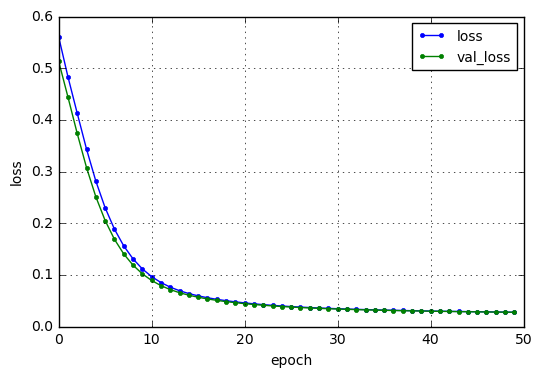

_AEdim=128_Win=2024_Sld=0253_sgd_NoiseFactor=0.01_denoising
Train on 4253 samples, validate on 4253 samples
Epoch 1/50
0s - loss: 0.5647 - val_loss: 0.5111
Epoch 2/50
0s - loss: 0.4855 - val_loss: 0.4425
Epoch 3/50
0s - loss: 0.4138 - val_loss: 0.3704
Epoch 4/50
0s - loss: 0.3426 - val_loss: 0.3032
Epoch 5/50
0s - loss: 0.2794 - val_loss: 0.2460
Epoch 6/50
0s - loss: 0.2270 - val_loss: 0.1999
Epoch 7/50
0s - loss: 0.1854 - val_loss: 0.1638
Epoch 8/50
0s - loss: 0.1531 - val_loss: 0.1361
Epoch 9/50
0s - loss: 0.1283 - val_loss: 0.1148
Epoch 10/50
0s - loss: 0.1093 - val_loss: 0.0987
Epoch 11/50
0s - loss: 0.0948 - val_loss: 0.0864
Epoch 12/50
0s - loss: 0.0837 - val_loss: 0.0770
Epoch 13/50
0s - loss: 0.0752 - val_loss: 0.0697
Epoch 14/50
0s - loss: 0.0686 - val_loss: 0.0640
Epoch 15/50
0s - loss: 0.0633 - val_loss: 0.0595
Epoch 16/50
0s - loss: 0.0591 - val_loss: 0.0558
Epoch 17/50
0s - loss: 0.0556 - val_loss: 0.0527
Epoch 18/50
0s - loss: 0.0526 - val_loss: 0.0501
Epoch 19/50
0s - lo

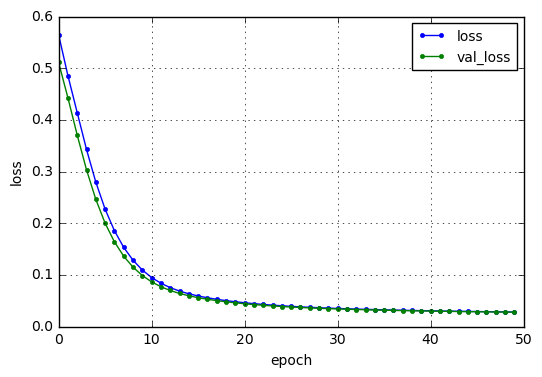

_AEdim=128_Win=2024_Sld=0253_sgd_NoiseFactor=0.05_denoising
Train on 4253 samples, validate on 4253 samples
Epoch 1/50
0s - loss: 0.6027 - val_loss: 0.5186
Epoch 2/50
0s - loss: 0.5270 - val_loss: 0.4505
Epoch 3/50
0s - loss: 0.4509 - val_loss: 0.3766
Epoch 4/50
0s - loss: 0.3736 - val_loss: 0.3065
Epoch 5/50
0s - loss: 0.3039 - val_loss: 0.2463
Epoch 6/50
0s - loss: 0.2458 - val_loss: 0.1978
Epoch 7/50
0s - loss: 0.1995 - val_loss: 0.1600
Epoch 8/50
0s - loss: 0.1635 - val_loss: 0.1312
Epoch 9/50
0s - loss: 0.1360 - val_loss: 0.1095
Epoch 10/50
0s - loss: 0.1151 - val_loss: 0.0932
Epoch 11/50
0s - loss: 0.0992 - val_loss: 0.0810
Epoch 12/50
0s - loss: 0.0872 - val_loss: 0.0718
Epoch 13/50
0s - loss: 0.0779 - val_loss: 0.0648
Epoch 14/50
0s - loss: 0.0708 - val_loss: 0.0595
Epoch 15/50
0s - loss: 0.0652 - val_loss: 0.0552
Epoch 16/50
0s - loss: 0.0607 - val_loss: 0.0518
Epoch 17/50
0s - loss: 0.0569 - val_loss: 0.0490
Epoch 18/50
0s - loss: 0.0538 - val_loss: 0.0465
Epoch 19/50
0s - lo

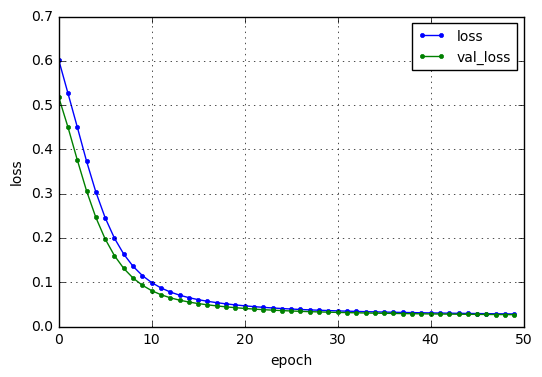

_AEdim=128_Win=2024_Sld=0253_sgd_NoiseFactor=00.1_denoising
Train on 4253 samples, validate on 4253 samples
Epoch 1/50
0s - loss: 0.6495 - val_loss: 0.5109
Epoch 2/50
0s - loss: 0.5577 - val_loss: 0.4349
Epoch 3/50
0s - loss: 0.4698 - val_loss: 0.3563
Epoch 4/50
0s - loss: 0.3844 - val_loss: 0.2849
Epoch 5/50
0s - loss: 0.3105 - val_loss: 0.2260
Epoch 6/50
0s - loss: 0.2505 - val_loss: 0.1798
Epoch 7/50
0s - loss: 0.2034 - val_loss: 0.1445
Epoch 8/50
0s - loss: 0.1671 - val_loss: 0.1180
Epoch 9/50
0s - loss: 0.1393 - val_loss: 0.0983
Epoch 10/50
0s - loss: 0.1182 - val_loss: 0.0837
Epoch 11/50
0s - loss: 0.1022 - val_loss: 0.0729
Epoch 12/50
0s - loss: 0.0900 - val_loss: 0.0649
Epoch 13/50
0s - loss: 0.0807 - val_loss: 0.0590
Epoch 14/50
0s - loss: 0.0734 - val_loss: 0.0544
Epoch 15/50
0s - loss: 0.0677 - val_loss: 0.0508
Epoch 16/50
0s - loss: 0.0631 - val_loss: 0.0478
Epoch 17/50
0s - loss: 0.0592 - val_loss: 0.0453
Epoch 18/50
0s - loss: 0.0560 - val_loss: 0.0432
Epoch 19/50
0s - lo

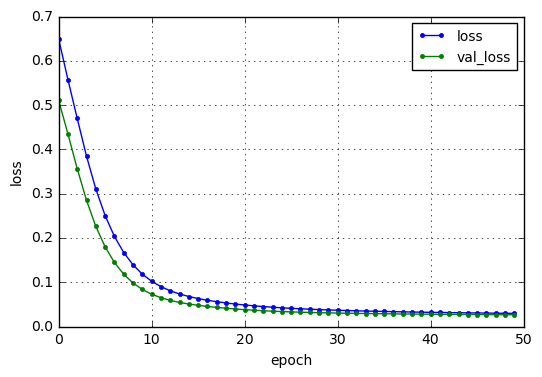

_AEdim=128_Win=2024_Sld=0253_sgd_NoiseFactor=00.5_denoising
Train on 4253 samples, validate on 4253 samples
Epoch 1/50
0s - loss: 1.0911 - val_loss: 0.4652
Epoch 2/50
0s - loss: 0.8875 - val_loss: 0.3459
Epoch 3/50
0s - loss: 0.6957 - val_loss: 0.2426
Epoch 4/50
0s - loss: 0.5381 - val_loss: 0.1675
Epoch 5/50
0s - loss: 0.4193 - val_loss: 0.1174
Epoch 6/50
0s - loss: 0.3324 - val_loss: 0.0858
Epoch 7/50
0s - loss: 0.2692 - val_loss: 0.0670
Epoch 8/50
0s - loss: 0.2233 - val_loss: 0.0566
Epoch 9/50
0s - loss: 0.1897 - val_loss: 0.0515
Epoch 10/50
0s - loss: 0.1651 - val_loss: 0.0494
Epoch 11/50
0s - loss: 0.1467 - val_loss: 0.0487
Epoch 12/50
0s - loss: 0.1327 - val_loss: 0.0483
Epoch 13/50
0s - loss: 0.1218 - val_loss: 0.0477
Epoch 14/50
0s - loss: 0.1130 - val_loss: 0.0465
Epoch 15/50
0s - loss: 0.1058 - val_loss: 0.0448
Epoch 16/50
0s - loss: 0.0999 - val_loss: 0.0431
Epoch 17/50
0s - loss: 0.0950 - val_loss: 0.0417
Epoch 18/50
0s - loss: 0.0908 - val_loss: 0.0408
Epoch 19/50
0s - lo

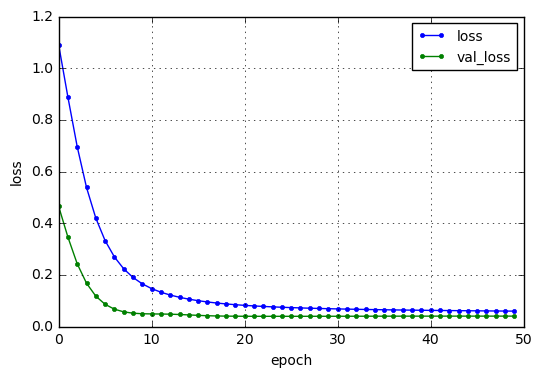

In [22]:
# loop windowWidth
WindowWidth = 2024
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
AEDimention = 128

WeightNoise=np.array([ 0.001,0.005,0.010,0.05,0.100,0.500 ])
windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowWidth,SlidingWidth,WindowDataPath)

for wn in WeightNoise:    
    windowNoise = windoW  + wn*np.random.normal\
    (loc=windoW.mean(),scale=windoW.std(),size=windoW.shape)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowWidth).zfill(4)+\
    '_Sld='+str(SlidingWidth).zfill(4)+'_'+Optim+'_NoiseFactor='+str(wn).zfill(4)\
    +'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windoW,AEDimention,Optim,CommonName,BatchSize)

# 検証内容4
ノイズの重みによって，学習の結果を検証してみる  
以下のパラメータで学習し結果を比較してみる  

Adamだとダメなのかもしれないので，一度ＳＧＤでやる  
ウィンドウフレームを大きくする

固定するパラメータ
* ウィンドウ幅 4048
* バッチサイズ 32
* 最適化関数　sgd
* 中間層の次元数 128

 10%|▉         | 207/2122 [00:00<00:00, 2056.65it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =2123
offset=90


100%|██████████| 2122/2122 [00:26<00:00, 37.70it/s]


_AEdim=128_Win=4048_Sld=0506_sgd_NoiseFactor=0.001_denoising
Train on 2123 samples, validate on 2123 samples
Epoch 1/50
0s - loss: 0.5783 - val_loss: 0.5648
Epoch 2/50
0s - loss: 0.5565 - val_loss: 0.5467
Epoch 3/50
0s - loss: 0.5394 - val_loss: 0.5297
Epoch 4/50
0s - loss: 0.5215 - val_loss: 0.5109
Epoch 5/50
0s - loss: 0.5018 - val_loss: 0.4903
Epoch 6/50
0s - loss: 0.4804 - val_loss: 0.4683
Epoch 7/50
0s - loss: 0.4580 - val_loss: 0.4456
Epoch 8/50
0s - loss: 0.4351 - val_loss: 0.4226
Epoch 9/50
0s - loss: 0.4122 - val_loss: 0.4000
Epoch 10/50
0s - loss: 0.3899 - val_loss: 0.3780
Epoch 11/50
0s - loss: 0.3682 - val_loss: 0.3569
Epoch 12/50
0s - loss: 0.3476 - val_loss: 0.3367
Epoch 13/50
0s - loss: 0.3280 - val_loss: 0.3177
Epoch 14/50
0s - loss: 0.3095 - val_loss: 0.2998
Epoch 15/50
0s - loss: 0.2921 - val_loss: 0.2830
Epoch 16/50
0s - loss: 0.2758 - val_loss: 0.2673
Epoch 17/50
0s - loss: 0.2606 - val_loss: 0.2527
Epoch 18/50
0s - loss: 0.2464 - val_loss: 0.2390
Epoch 19/50
0s - l

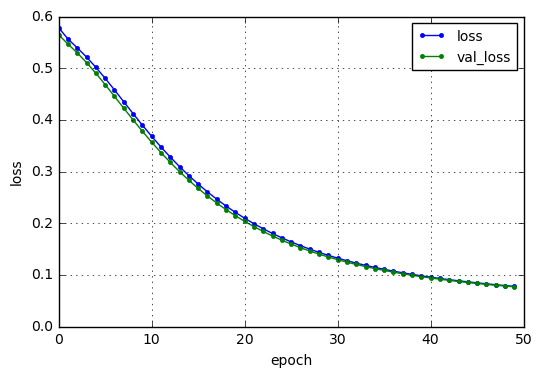

_AEdim=128_Win=4048_Sld=0506_sgd_NoiseFactor=0.005_denoising
Train on 2123 samples, validate on 2123 samples
Epoch 1/50
0s - loss: 0.5835 - val_loss: 0.5642
Epoch 2/50
0s - loss: 0.5587 - val_loss: 0.5444
Epoch 3/50
0s - loss: 0.5399 - val_loss: 0.5262
Epoch 4/50
0s - loss: 0.5211 - val_loss: 0.5066
Epoch 5/50
0s - loss: 0.5005 - val_loss: 0.4853
Epoch 6/50
0s - loss: 0.4782 - val_loss: 0.4626
Epoch 7/50
0s - loss: 0.4550 - val_loss: 0.4392
Epoch 8/50
0s - loss: 0.4314 - val_loss: 0.4158
Epoch 9/50
0s - loss: 0.4081 - val_loss: 0.3929
Epoch 10/50
0s - loss: 0.3855 - val_loss: 0.3708
Epoch 11/50
0s - loss: 0.3638 - val_loss: 0.3498
Epoch 12/50
0s - loss: 0.3431 - val_loss: 0.3298
Epoch 13/50
0s - loss: 0.3236 - val_loss: 0.3110
Epoch 14/50
0s - loss: 0.3052 - val_loss: 0.2933
Epoch 15/50
0s - loss: 0.2880 - val_loss: 0.2768
Epoch 16/50
0s - loss: 0.2719 - val_loss: 0.2613
Epoch 17/50
0s - loss: 0.2568 - val_loss: 0.2469
Epoch 18/50
0s - loss: 0.2427 - val_loss: 0.2334
Epoch 19/50
0s - l

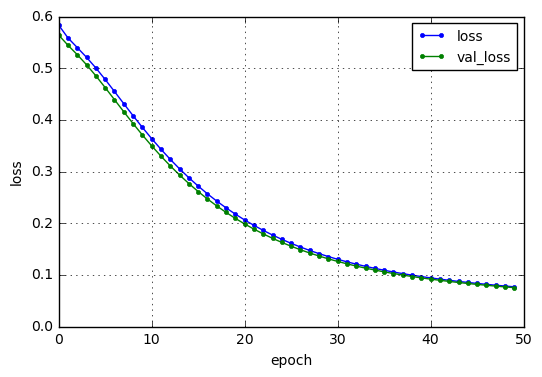

_AEdim=128_Win=4048_Sld=0506_sgd_NoiseFactor=0.01_denoising
Train on 2123 samples, validate on 2123 samples
Epoch 1/50
0s - loss: 0.5824 - val_loss: 0.5607
Epoch 2/50
0s - loss: 0.5608 - val_loss: 0.5430
Epoch 3/50
0s - loss: 0.5437 - val_loss: 0.5261
Epoch 4/50
0s - loss: 0.5258 - val_loss: 0.5076
Epoch 5/50
0s - loss: 0.5062 - val_loss: 0.4874
Epoch 6/50
0s - loss: 0.4849 - val_loss: 0.4658
Epoch 7/50
0s - loss: 0.4627 - val_loss: 0.4435
Epoch 8/50
0s - loss: 0.4401 - val_loss: 0.4212
Epoch 9/50
0s - loss: 0.4177 - val_loss: 0.3992
Epoch 10/50
0s - loss: 0.3957 - val_loss: 0.3777
Epoch 11/50
0s - loss: 0.3743 - val_loss: 0.3571
Epoch 12/50
0s - loss: 0.3538 - val_loss: 0.3373
Epoch 13/50
0s - loss: 0.3343 - val_loss: 0.3185
Epoch 14/50
0s - loss: 0.3158 - val_loss: 0.3007
Epoch 15/50
0s - loss: 0.2982 - val_loss: 0.2839
Epoch 16/50
0s - loss: 0.2818 - val_loss: 0.2682
Epoch 17/50
0s - loss: 0.2663 - val_loss: 0.2535
Epoch 18/50
0s - loss: 0.2519 - val_loss: 0.2397
Epoch 19/50
0s - lo

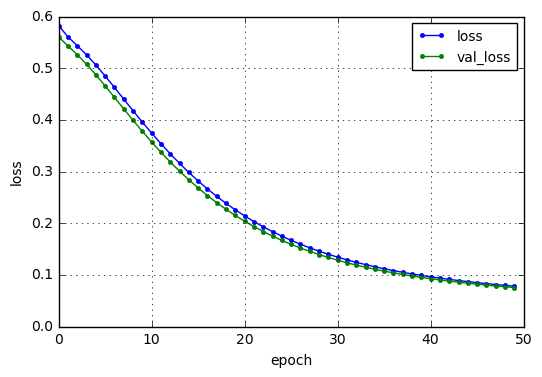

_AEdim=128_Win=4048_Sld=0506_sgd_NoiseFactor=0.05_denoising
Train on 2123 samples, validate on 2123 samples
Epoch 1/50
0s - loss: 0.6233 - val_loss: 0.5606
Epoch 2/50
0s - loss: 0.5968 - val_loss: 0.5411
Epoch 3/50
0s - loss: 0.5764 - val_loss: 0.5215
Epoch 4/50
0s - loss: 0.5544 - val_loss: 0.4997
Epoch 5/50
0s - loss: 0.5303 - val_loss: 0.4762
Epoch 6/50
0s - loss: 0.5048 - val_loss: 0.4516
Epoch 7/50
0s - loss: 0.4786 - val_loss: 0.4269
Epoch 8/50
0s - loss: 0.4525 - val_loss: 0.4024
Epoch 9/50
0s - loss: 0.4270 - val_loss: 0.3787
Epoch 10/50
0s - loss: 0.4024 - val_loss: 0.3561
Epoch 11/50
0s - loss: 0.3790 - val_loss: 0.3346
Epoch 12/50
0s - loss: 0.3568 - val_loss: 0.3144
Epoch 13/50
0s - loss: 0.3360 - val_loss: 0.2954
Epoch 14/50
0s - loss: 0.3164 - val_loss: 0.2777
Epoch 15/50
0s - loss: 0.2981 - val_loss: 0.2612
Epoch 16/50
0s - loss: 0.2811 - val_loss: 0.2458
Epoch 17/50
0s - loss: 0.2652 - val_loss: 0.2316
Epoch 18/50
0s - loss: 0.2505 - val_loss: 0.2184
Epoch 19/50
0s - lo

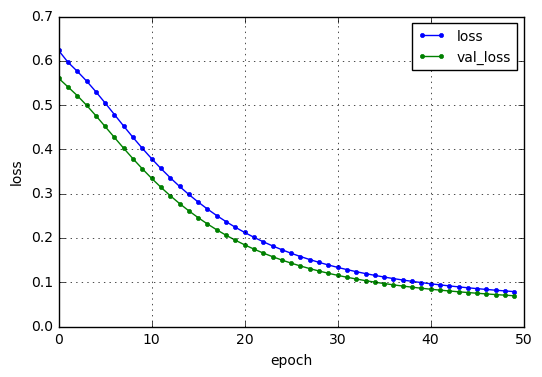

_AEdim=128_Win=4048_Sld=0506_sgd_NoiseFactor=00.1_denoising
Train on 2123 samples, validate on 2123 samples
Epoch 1/50
0s - loss: 0.6745 - val_loss: 0.5617
Epoch 2/50
0s - loss: 0.6452 - val_loss: 0.5393
Epoch 3/50
0s - loss: 0.6206 - val_loss: 0.5175
Epoch 4/50
0s - loss: 0.5953 - val_loss: 0.4942
Epoch 5/50
0s - loss: 0.5683 - val_loss: 0.4695
Epoch 6/50
0s - loss: 0.5400 - val_loss: 0.4439
Epoch 7/50
0s - loss: 0.5113 - val_loss: 0.4183
Epoch 8/50
0s - loss: 0.4829 - val_loss: 0.3933
Epoch 9/50
0s - loss: 0.4554 - val_loss: 0.3691
Epoch 10/50
0s - loss: 0.4289 - val_loss: 0.3461
Epoch 11/50
0s - loss: 0.4037 - val_loss: 0.3244
Epoch 12/50
0s - loss: 0.3800 - val_loss: 0.3040
Epoch 13/50
0s - loss: 0.3576 - val_loss: 0.2848
Epoch 14/50
0s - loss: 0.3367 - val_loss: 0.2670
Epoch 15/50
0s - loss: 0.3171 - val_loss: 0.2504
Epoch 16/50
0s - loss: 0.2988 - val_loss: 0.2350
Epoch 17/50
0s - loss: 0.2818 - val_loss: 0.2208
Epoch 18/50
0s - loss: 0.2660 - val_loss: 0.2076
Epoch 19/50
0s - lo

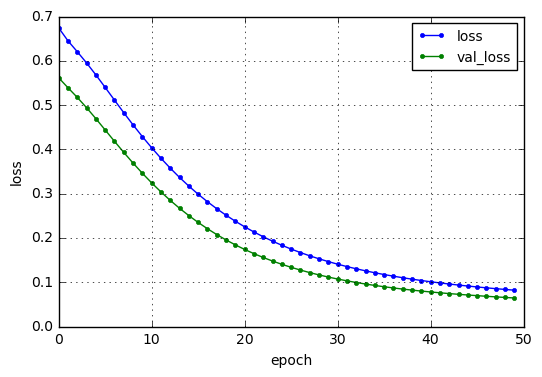

_AEdim=128_Win=4048_Sld=0506_sgd_NoiseFactor=00.5_denoising
Train on 2123 samples, validate on 2123 samples
Epoch 1/50
0s - loss: 1.1673 - val_loss: 0.5487
Epoch 2/50
0s - loss: 1.1067 - val_loss: 0.5159
Epoch 3/50
0s - loss: 1.0507 - val_loss: 0.4811
Epoch 4/50
0s - loss: 0.9915 - val_loss: 0.4442
Epoch 5/50
0s - loss: 0.9309 - val_loss: 0.4071
Epoch 6/50
0s - loss: 0.8712 - val_loss: 0.3713
Epoch 7/50
0s - loss: 0.8140 - val_loss: 0.3375
Epoch 8/50
0s - loss: 0.7599 - val_loss: 0.3062
Epoch 9/50
0s - loss: 0.7094 - val_loss: 0.2775
Epoch 10/50
0s - loss: 0.6624 - val_loss: 0.2515
Epoch 11/50
0s - loss: 0.6190 - val_loss: 0.2280
Epoch 12/50
0s - loss: 0.5789 - val_loss: 0.2069
Epoch 13/50
0s - loss: 0.5419 - val_loss: 0.1879
Epoch 14/50
0s - loss: 0.5079 - val_loss: 0.1711
Epoch 15/50
0s - loss: 0.4766 - val_loss: 0.1561
Epoch 16/50
0s - loss: 0.4477 - val_loss: 0.1427
Epoch 17/50
0s - loss: 0.4212 - val_loss: 0.1309
Epoch 18/50
0s - loss: 0.3968 - val_loss: 0.1205
Epoch 19/50
0s - lo

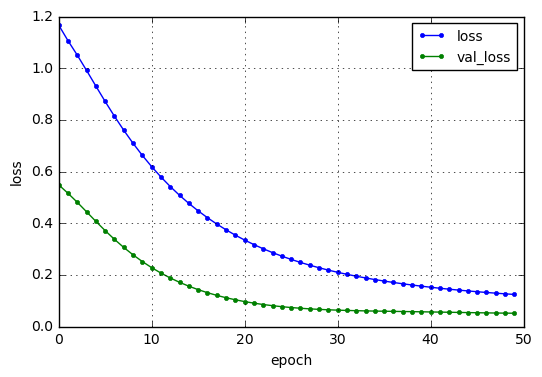

In [23]:
# loop windowWidth
WindowWidth = 4048
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
AEDimention = 128

WeightNoise=np.array([ 0.001,0.005,0.010,0.05,0.100,0.500 ])
windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowWidth,SlidingWidth,WindowDataPath)

for wn in WeightNoise:    
    windowNoise = windoW  + wn*np.random.normal\
    (loc=windoW.mean(),scale=windoW.std(),size=windoW.shape)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowWidth).zfill(4)+\
    '_Sld='+str(SlidingWidth).zfill(4)+'_'+Optim+'_NoiseFactor='+str(wn).zfill(4)\
    +'_denoising'
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windowNoise,windoW,AEDimention,Optim,CommonName,BatchSize)